# Speech Emotion Recognition - LSTM Model

### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import IPython
import librosa # librosa is a Python library for analyzing audio and music used to extract the data from audio files it later
import librosa.display
from IPython.display import Audio # to play the audio files
plt.style.use('seaborn-white')
from python_speech_features import mfcc

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import concatenate
from keras.models import Model
from keras.layers.normalization import layer_normalization
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM
from keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.utils import np_utils, to_categorical

import torch
from pytorch_transformers import GPT2Tokenizer, GPT2LMHeadModel
import speech_recognition as sr

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

C:\Users\TestUser\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Read csv file

In [2]:
feat = pd.read_csv('feat.csv')

feat.head()

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,labels
0,-399.535004,76.428391,-23.082157,-18.684132,1.685362,15.067113,-21.209391,-5.796458,-6.386797,3.003888,...,0.434596,0.412372,0.373666,0.568295,0.573150,0.404191,0.469243,0.525294,1487.683221,Angry
1,-163.356796,16.288073,-4.017271,-9.704623,-1.823467,0.891731,-2.793187,-5.654695,-3.320916,-0.029738,...,0.683682,0.668844,0.519446,0.654436,0.713587,0.593206,0.615255,0.660334,4569.698260,Angry
2,-412.039398,77.262421,-32.583839,-24.591434,4.346249,9.090682,-26.384003,-4.067521,-6.408696,4.251380,...,0.351096,0.422755,0.433503,0.356062,0.580109,0.609401,0.420695,0.462002,1686.632515,Angry
3,-431.256287,75.581871,-25.508471,-20.642477,1.065045,14.736607,-22.362364,-6.727914,-6.420148,3.231606,...,0.413919,0.406536,0.359708,0.557236,0.573689,0.396855,0.461476,0.535765,1548.812463,Angry
4,-391.680115,94.263718,-27.733862,-28.800610,-2.881231,13.102319,-28.031700,-10.077882,-9.727766,2.450062,...,0.425077,0.347824,0.328270,0.633562,0.555491,0.397686,0.483802,0.523931,1539.644752,Angry


### Data Preparation

In [3]:
X = feat.drop(['labels'], axis = 1)

y = feat['labels']

In [4]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,-399.535004,76.428391,-23.082157,-18.684132,1.685362,15.067113,-21.209391,-5.796458,-6.386797,3.003888,...,0.362415,0.434596,0.412372,0.373666,0.568295,0.573150,0.404191,0.469243,0.525294,1487.683221
1,-163.356796,16.288073,-4.017271,-9.704623,-1.823467,0.891731,-2.793187,-5.654695,-3.320916,-0.029738,...,0.624722,0.683682,0.668844,0.519446,0.654436,0.713587,0.593206,0.615255,0.660334,4569.698260
2,-412.039398,77.262421,-32.583839,-24.591434,4.346249,9.090682,-26.384003,-4.067521,-6.408696,4.251380,...,0.424115,0.351096,0.422755,0.433503,0.356062,0.580109,0.609401,0.420695,0.462002,1686.632515
3,-431.256287,75.581871,-25.508471,-20.642477,1.065045,14.736607,-22.362364,-6.727914,-6.420148,3.231606,...,0.346212,0.413919,0.406536,0.359708,0.557236,0.573689,0.396855,0.461476,0.535765,1548.812463
4,-391.680115,94.263718,-27.733862,-28.800610,-2.881231,13.102319,-28.031700,-10.077882,-9.727766,2.450062,...,0.326723,0.425077,0.347824,0.328270,0.633562,0.555491,0.397686,0.483802,0.523931,1539.644752


In [5]:
y.value_counts()

Angry       2400
Disgust     2400
Fear        2400
Happy       2400
Neutral     2400
Surprise    2400
Sad         2400
Name: labels, dtype: int64

In [6]:
y.head()

0    Angry
1    Angry
2    Angry
3    Angry
4    Angry
Name: labels, dtype: object

This is a multiclass classification problem so I must onehot encode y

In [7]:
onehot = OneHotEncoder()

np_onehot = np.array(y).reshape(-1, 1)

y = onehot.fit_transform(np_onehot).toarray()

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Train, test, split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13440, 163), (13440, 7), (3360, 163), (3360, 7))

Scale the data using Standard Scaler

In [10]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

Insert a new axis that will appear at the axis position in the expanded array shape to make data suitable to model.

In [11]:
X_train = np.expand_dims(X_train, axis = 2)

X_test = np.expand_dims(X_test, axis = 2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13440, 163, 1), (13440, 7), (3360, 163, 1), (3360, 7))

### LSTM Model

Long Short-Term Memory Networks

In [12]:
model_lstm = keras.Sequential(name = 'SER-LSTM')

model_lstm.add(LSTM(units = 64,
                    return_sequences = True,
                    input_shape = (X_train.shape[1], 1)))

model_lstm.add(Dense(units = 64, activation = 'softmax'))

model_lstm.add(Dropout(0.2))

model_lstm.add(Flatten())

model_lstm.add(Dense(units = 7, activation = 'softmax'))

model_lstm.summary()

Model: "SER-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 163, 64)           16896     
                                                                 
 dense (Dense)               (None, 163, 64)           4160      
                                                                 
 dropout (Dropout)           (None, 163, 64)           0         
                                                                 
 flatten (Flatten)           (None, 10432)             0         
                                                                 
 dense_1 (Dense)             (None, 7)                 73031     
                                                                 
Total params: 94,087
Trainable params: 94,087
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_lstm.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy' , 
              metrics = ['categorical_accuracy'])

In [14]:
history_lstm = model_lstm.fit(X_train, 
                    y_train,
                    batch_size = 128,
                    epochs = 10,
                    validation_data = (X_test, y_test))

Epoch 1/10
105/105 [==============================] - 68s 525ms/step - loss: 1.6121 - categorical_accuracy: 0.3836 - val_loss: 1.1823 - val_categorical_accuracy: 0.6015
Epoch 2/10
105/105 [==============================] - 52s 496ms/step - loss: 0.8926 - categorical_accuracy: 0.6946 - val_loss: 0.6514 - val_categorical_accuracy: 0.7777
Epoch 3/10
105/105 [==============================] - 55s 523ms/step - loss: 0.5503 - categorical_accuracy: 0.8076 - val_loss: 0.4228 - val_categorical_accuracy: 0.8601
Epoch 4/10
105/105 [==============================] - 54s 512ms/step - loss: 0.3814 - categorical_accuracy: 0.8719 - val_loss: 0.3068 - val_categorical_accuracy: 0.9015
Epoch 5/10
105/105 [==============================] - 54s 517ms/step - loss: 0.2875 - categorical_accuracy: 0.9088 - val_loss: 0.2408 - val_categorical_accuracy: 0.9259
Epoch 6/10
105/105 [==============================] - 54s 511ms/step - loss: 0.2500 - categorical_accuracy: 0.9216 - val_loss: 0.2046 - val_categorical_acc

In [15]:
score_lstm = model_lstm.evaluate(X_test, y_test)

print('Test loss:', score_lstm[0])

print('Test accuracy:', score_lstm[1])

105/105 [==============================] - 7s 63ms/step - loss: 0.1347 - categorical_accuracy: 0.9619
Test loss: 0.13468089699745178
Test accuracy: 0.961904764175415


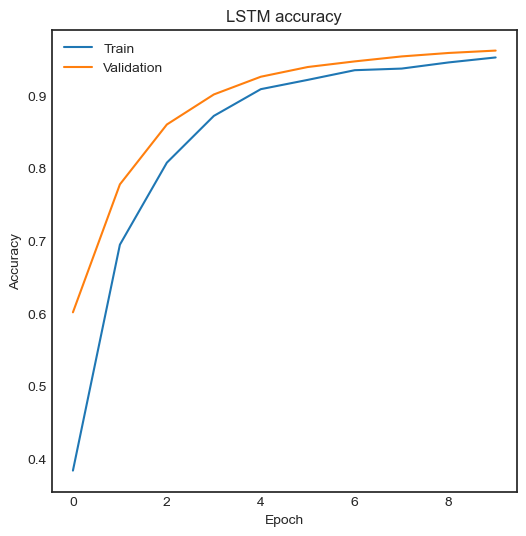

In [16]:
plt.figure(figsize = (6, 6))
plt.title('LSTM accuracy')

plt.plot(history_lstm.history['categorical_accuracy'])
plt.plot(history_lstm.history['val_categorical_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

Predict on test data

In [17]:
pred_lstm = model_lstm.predict(X_test)

y_pred_lstm = onehot.inverse_transform(pred_lstm)

y_test_lstm = onehot.inverse_transform(y_test)

105/105 [==============================] - 9s 60ms/step


In [18]:
df_lstm = pd.DataFrame(columns = ['Predicted', 'Actual'])

df_lstm['Predicted'] = y_pred_lstm.flatten()

df_lstm['Actual'] = y_test_lstm.flatten()

df_lstm.head(10)

,Predicted,Actual
0,Fear,Fear
1,Fear,Fear
2,Happy,Happy
3,Sad,Sad
4,Neutral,Neutral
5,Fear,Fear
6,Surprise,Surprise
7,Sad,Sad
8,Surprise,Surprise
9,Sad,Sad


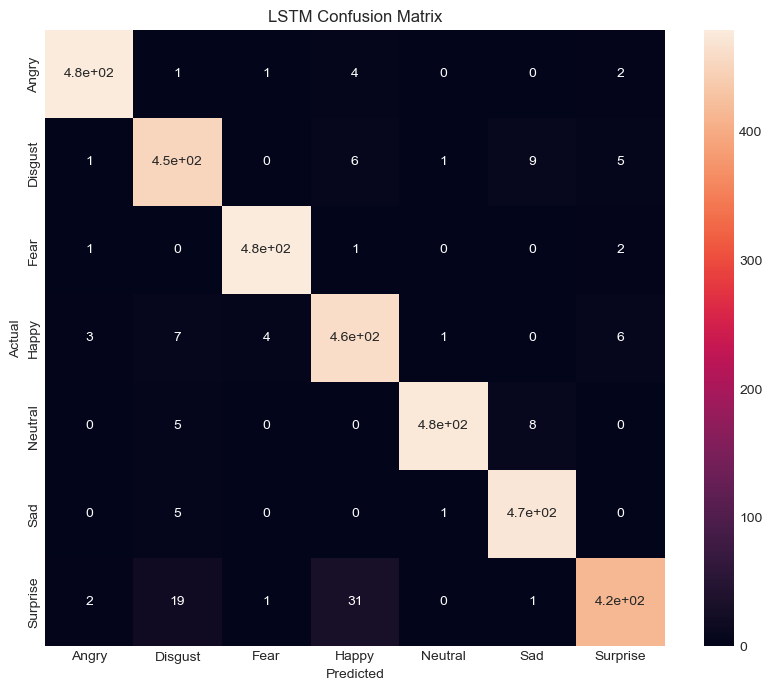

In [19]:
confusion_matrix_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize = (10, 8))

confusion_matrix_lstm = pd.DataFrame(confusion_matrix_lstm, 
                                    index = [x for x in onehot.categories_], 
                                    columns = [c for c in onehot.categories_])

sns.heatmap(confusion_matrix_lstm, 
            annot = True)

plt.title('LSTM Confusion Matrix')

plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.show()

In [20]:
print(classification_report(y_test_lstm, y_pred_lstm))

              precision    recall  f1-score   support

       Angry       0.99      0.98      0.98       486
     Disgust       0.92      0.95      0.94       473
        Fear       0.99      0.99      0.99       483
       Happy       0.92      0.96      0.94       482
     Neutral       0.99      0.97      0.98       488
         Sad       0.96      0.99      0.98       479
    Surprise       0.97      0.88      0.92       469

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360



In [21]:
tf.keras.models.save_model(model_lstm, 'model_lstm.hdf5')